# Portfolio Optimization

Comprehensive portfolio optimization tool that includes:

- Data collection and preprocessing for a set of stocks
- Risk and return calculations
- Efficient frontier visualization
- Optimal portfolio weights calculation
- Performance comparison with benchmark indices

=== Downloading Data ===
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  6 of 6 completed


Data loaded and preprocessed successfully.

=== Calculating Risk & Return ===
Expected Annual Returns:
Ticker
AAPL     0.442217
MSFT     0.465174
GOOGL    0.454857
AMZN     0.578116
TSLA     0.842333
dtype: float64

Annualized Covariance Matrix:
Ticker      AAPL      MSFT     GOOGL      AMZN      TSLA
Ticker                                                  
AAPL    0.039689  0.027290  0.031942  0.028786  0.046247
MSFT    0.027290  0.062544  0.038492  0.047494  0.041906
GOOGL   0.031942  0.038492  0.092727  0.060364  0.053512
AMZN    0.028786  0.047494  0.060364  0.108377  0.064480
TSLA    0.046247  0.041906  0.053512  0.064480  0.274437 

=== Simulating Random Portfolios for Efficient Frontier ===


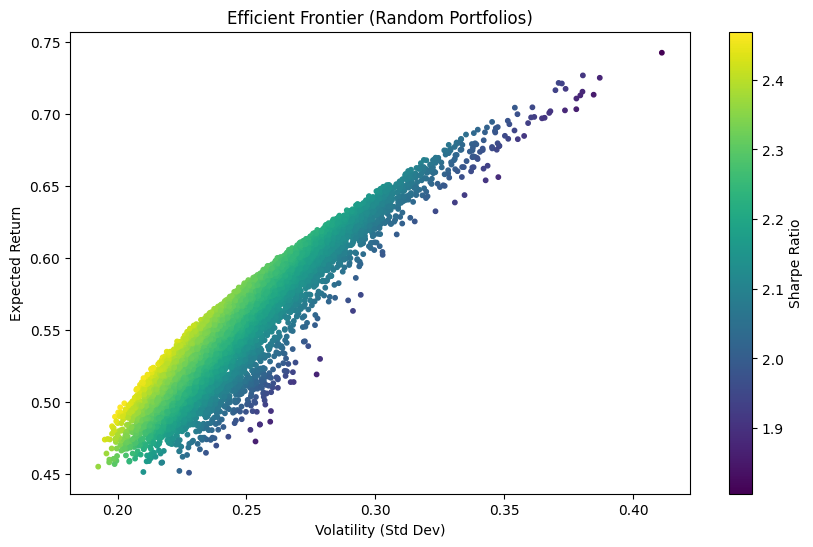

=== Finding Maximum Sharpe Ratio Portfolio ===
AAPL     5.713156e-01
MSFT     1.862399e-01
GOOGL    6.551292e-17
AMZN     1.500044e-01
TSLA     9.244010e-02
Name: Optimal Weights, dtype: float64 

Optimal Portfolio Return: 50.39%
Optimal Portfolio Volatility: 20.35%
Optimal Portfolio Sharpe Ratio: 2.48

=== Comparing Portfolio vs. Benchmark ===


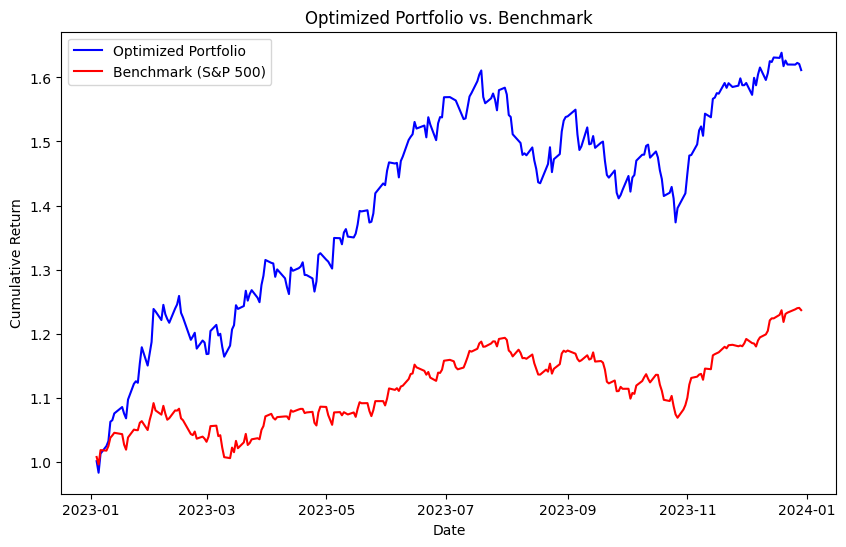

Portfolio Optimization completed successfully!


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

########################################
# 1. Data Collection & Preprocessing
########################################
# Define stock tickers and benchmark
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
benchmark = '^GSPC'  # S&P 500

# Define time range
start_date = '2023-01-01'
end_date = '2024-01-01'

print("=== Downloading Data ===")
# Download Adjusted Close prices
data = yf.download(tickers + [benchmark], start=start_date, end=end_date)['Close']

# Drop rows with missing values
data.dropna(inplace=True)

# Separate portfolio (stocks) and benchmark data
portfolio_data = data[tickers]
benchmark_data = data[benchmark]

# Compute daily log returns
portfolio_returns = np.log(portfolio_data / portfolio_data.shift(1)).dropna()
benchmark_returns = np.log(benchmark_data / benchmark_data.shift(1)).dropna()

print("Data loaded and preprocessed successfully.\n")

########################################
# 2. Risk & Return Calculations
########################################
print("=== Calculating Risk & Return ===")
# Annualize returns (assuming ~252 trading days per year)
expected_returns = portfolio_returns.mean() * 252
cov_matrix = portfolio_returns.cov() * 252

print("Expected Annual Returns:")
print(expected_returns)
print("\nAnnualized Covariance Matrix:")
print(cov_matrix, "\n")

########################################
# 3. Efficient Frontier Visualization
########################################
print("=== Simulating Random Portfolios for Efficient Frontier ===")
num_portfolios = 10_000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    # Random weight distribution
    w = np.random.random(len(tickers))
    w /= np.sum(w)
    weights_record.append(w)
    
    # Portfolio metrics
    port_return = np.sum(w * expected_returns)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    sharpe_ratio = port_return / port_vol  # Assuming risk-free rate = 0
    
    results[0, i] = port_return
    results[1, i] = port_vol
    results[2, i] = sharpe_ratio

plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier (Random Portfolios)')
plt.show()

########################################
# 4. Optimal Portfolio Weights Calculation
########################################
print("=== Finding Maximum Sharpe Ratio Portfolio ===")
def neg_sharpe(weights, exp_ret, cov_mat):
    port_return = np.sum(weights * exp_ret)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    return -(port_return / port_vol)  # negative for minimization

def constraint_sum(weights):
    return np.sum(weights) - 1

# Initial guess (equal weights)
init_guess = np.ones(len(tickers)) / len(tickers)

# Bounds: all weights between 0 and 1
bounds = [(0.0, 1.0)] * len(tickers)

# Constraints: sum of weights == 1
constraints = [{'type': 'eq', 'fun': constraint_sum}]

# Optimize
opt_result = minimize(neg_sharpe, init_guess,
                      args=(expected_returns, cov_matrix),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
optimal_weights = opt_result.x

optimal_portfolio = pd.Series(optimal_weights, index=tickers, name='Optimal Weights')
print(optimal_portfolio, "\n")

# Calculate metrics for optimal portfolio
opt_return = np.sum(optimal_weights * expected_returns)
opt_vol = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
opt_sharpe = opt_return / opt_vol

print(f"Optimal Portfolio Return: {opt_return:.2%}")
print(f"Optimal Portfolio Volatility: {opt_vol:.2%}")
print(f"Optimal Portfolio Sharpe Ratio: {opt_sharpe:.2f}\n")

########################################
# 5. Performance Comparison with Benchmark
########################################
print("=== Comparing Portfolio vs. Benchmark ===")
# Construct daily returns of the optimized portfolio
portfolio_daily_returns = (portfolio_returns * optimal_weights).sum(axis=1)

# Cumulative returns
cumulative_portfolio = (1 + portfolio_daily_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns).cumprod()

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio.index, cumulative_portfolio, label='Optimized Portfolio', color='blue')
plt.plot(cumulative_benchmark.index, cumulative_benchmark, label='Benchmark (S&P 500)', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Optimized Portfolio vs. Benchmark')
plt.legend()
plt.show()

print("Portfolio Optimization completed successfully!")
